In [2]:
import os
import io
import base64
import time

import numpy as np
from scipy.spatial.transform import Rotation as R
import trimesh
import open3d as o3d
from PIL import Image

from openai import OpenAI

from annotation import Annotation

from acronym_tools import load_mesh, load_grasps, create_gripper_marker, Scene
from viz_grasp_viewpoints import trimesh_to_o3d, GeomRenderer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
DATA_DIR = "/root/abhayd/acronym/data"
SUPPORT = "Table_45587567f6f4d20cf004563556ddb36_0.005493972811728752.h5"
TASK = "Pour water from a bottle"

In [5]:
def datafile_path(root, obj_category, obj_id):
    return os.path.join(root, "grasps", f"{obj_category}_{obj_id}.h5")

support_mesh: trimesh.Trimesh = load_mesh(os.path.join(DATA_DIR, "grasps", SUPPORT), DATA_DIR, scale=0.025)
support_mesh.vertices -= support_mesh.centroid

with open("../annotations.jsonl", "r") as f:
    annotations = [Annotation.model_validate_json(line) for line in f if line.strip()]

obj_set = set()
for annot in annotations:
    obj_set.add((annot.obj.object_category, annot.obj.object_id))

meshes: dict[tuple, trimesh.Trimesh] = {k: load_mesh(datafile_path(DATA_DIR, k[0], k[1]), DATA_DIR) for k in obj_set}
grasps = {k: load_grasps(datafile_path(DATA_DIR, k[0], k[1]))[0] for k in obj_set}

for k, grasp in grasps.items():
    grasp[...,:3,3] -= meshes[k].centroid
for mesh in meshes.values():
    mesh.vertices -= mesh.centroid

objs = list(obj_set)
succ = False
while not succ:
    scene = Scene.random_arrangement([meshes[o] for o in objs], support_mesh)
    succ = len(scene._objects) == len(objs) + 1

Placing meshes: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0xc000010 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


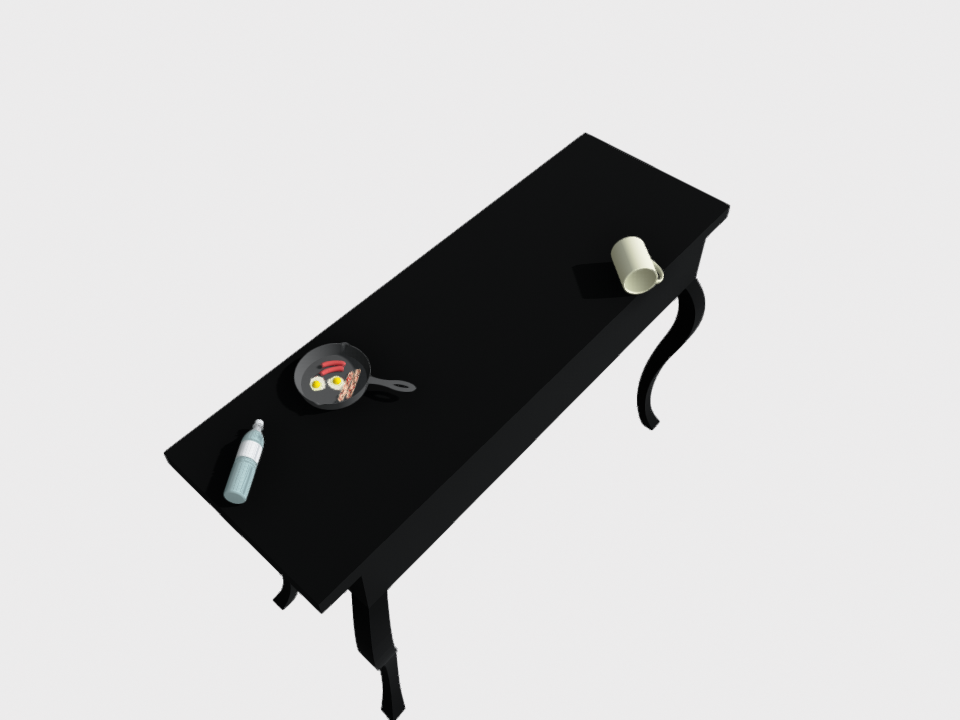

In [6]:
scene_trimesh = scene.as_trimesh_scene()
scene_mesh = trimesh_to_o3d(scene_trimesh.to_mesh())

w, h = 960, 720
fov_x, fov_y = 60, 45
cam_info = np.array([
    [(w/2) / np.tan(np.radians(fov_x/2)), 0, w/2],
    [0, (h/2) / np.tan(np.radians(fov_y/2)), h/2],
    [0, 0, 1]
])
renderer = GeomRenderer(w, h)
theta = np.random.uniform(-np.pi, np.pi)
elevation = np.random.uniform(np.pi/6, np.pi/3)
cam_pos = R.from_euler("xz", [elevation, theta]).apply(np.array([0, scene_trimesh.bounding_sphere.primitive.radius * 2.5, 0]))
z_ax = -cam_pos / np.linalg.norm(cam_pos)
x_ax = np.cross(z_ax, np.array([0, 0, 1]))
x_ax /= np.linalg.norm(x_ax)
y_ax = np.cross(z_ax, x_ax)
cam_pose = np.eye(4)
cam_pose[:3,:3] = np.column_stack((x_ax, y_ax, z_ax))
cam_pose[:3,3] = cam_pos
img = renderer.render([scene_mesh], cam_info, np.linalg.inv(cam_pose))
Image.fromarray(img).show()

In [7]:
buf = io.BytesIO()
Image.fromarray(img).save("tmp.png")
Image.fromarray(img).save(buf, format="JPEG")
img_encoded = base64.b64encode(buf.getvalue()).decode("utf-8")
buf.seek(0)

import subprocess
key = subprocess.run(["beaker", "secret", "read", "OPENAI_API_KEY"], stdout=subprocess.PIPE).stdout.decode("utf-8").strip()
client = OpenAI(api_key=key)
assistant = client.beta.assistants.retrieve("asst_xRaGdGI53GPue3vuVLyOFPfr")

uploaded = client.files.create(
    file=open("tmp.png", "rb"),
    purpose="vision"
)

thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"Describe the best grasp for the task \"{TASK}\"."
                },
                {
                    "type": "image_file",
                    "image_file": {
                        "file_id": uploaded.id
                    }
                }
            ]
        }
    ]
)
start = time.perf_counter()
run = client.beta.threads.runs.create_and_poll(
    thread_id=thread.id,
    assistant_id=assistant.id
)
print(f"Run status: {run.status} elapsed: {time.perf_counter() - start:.4f}")
while run.status not in ["completed", "failed", "cancelled", "expired"]:
    print(f"Run status: {run.status}")
    time.sleep(1)
client.files.delete(uploaded.id)

messages = client.beta.threads.messages.list(thread_id=thread.id)
proposal_text = messages.data[0].content[0].text.value.rsplit("\n", 1)[-1].strip()

Defaulting to workspace ai2/abhayd


Run status: completed elapsed: 11.6136


In [8]:
import torch
from sentence_transformers import SentenceTransformer

query_prefix = "Instruct: Given a description of a grasp, retrieve grasp descriptions that describe similar grasps on similar objects\nQuery: "

candidate_texts = []
for annot in annotations:
    candidate_texts.append(annot.description)

if "nv_embed" not in globals():
    nv_embed = SentenceTransformer('nvidia/NV-Embed-v2', trust_remote_code=True)
    nv_embed.max_seq_length = 32768
    nv_embed.tokenizer.padding_side="right"

def add_eos(input_examples):
    input_examples = [input_example + nv_embed.tokenizer.eos_token for input_example in input_examples]
    return input_examples

# get the embeddings
batch_size = 4
with torch.no_grad():
    start = time.perf_counter()
    query_embeddings = nv_embed.encode(add_eos([proposal_text]), batch_size=batch_size, prompt=query_prefix, normalize_embeddings=True)
    passage_embeddings = nv_embed.encode(add_eos(candidate_texts), batch_size=batch_size, normalize_embeddings=True)
    elapsed = time.perf_counter() - start

scores = (query_embeddings @ passage_embeddings.T).flatten()
rankings: list[int] = np.argsort(scores)[::-1].tolist()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/net/nfs2.prior/abhayd/envs/torch/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [9]:
valid_annot_idxs = []
gripper_mesh = trimesh.load(os.path.join(DATA_DIR, "franka_gripper_collision_mesh.stl"))
scene_trimesh_grasp = scene_trimesh.copy()
for idx in rankings:
    annot = annotations[idx]
    obj_key = (annot.obj.object_category, annot.obj.object_id)
    obj_idx = objs.index(obj_key)
    obj_pose = scene._poses[f"obj{obj_idx}"]
    t = grasps[obj_key][annot.grasp_id]
    grasp_pose = np.dot(obj_pose, t)
    if not scene.in_collision_with(gripper_mesh, transform=grasp_pose):
        if len(valid_annot_idxs) == 0:
            gripper_marker = create_gripper_marker(color=[0,255,0]).apply_transform(grasp_pose)
            scene_trimesh_grasp.add_geometry(gripper_marker)
        valid_annot_idxs.append(idx) 
    else:
        print(f"Grasp in collision: {annot.description}")
        # break
if len(valid_annot_idxs) == 0:
    print("No valid grasp found")

Grasp in collision: The grasp is on the body of the bottle, approximately one-third from the base of the bottle. The grasp is flat, oriented parallel to the base and grasping the bottle from the sides.
Grasp in collision: The grasp is on the neck of the bottle, just below the bottlecap. The grasp is coming from above at a diagonal angle, grasping the neck by the sides.
Grasp in collision: The grasp is on the body of the bottle, grasping the bottle on the sides. The grasp is from the side, perpendicular to the length of the bottle.
Grasp in collision: The grasp is on the base of the bottle, coming from below. The grasp is parallel to the length of the bottle.
Grasp in collision: The grasp is on the body of the bottle, about two-thirds of the length from the base. The grasp is flat, oriented perpendicular to the length of the bottle, grasping the bottle from the sides.
Grasp in collision: Grasp is on the bottlecap, oriented parallel to the length of the bottle, coming from above.
Grasp i

In [10]:
print(f"Proposal: {proposal_text}\n")
for i, idx in enumerate(valid_annot_idxs):
    print(f"Rank {i+1}: score={scores[idx]:.3f} {annotations[idx].description}")

Proposal: The best place to grasp the bottle is around its neck, just below the cap. This location allows for minimal interference with the bottle's opening during the pour, while offering greater control due to the narrower diameter compared to the body of the bottle. Orient the gripper such that the contact surfaces are perpendicular to the length of the bottle neck, with a parallel alignment to each other to ensure stabilization of the bottle during maneuvering. This placement will provide sufficient grip to both tilt and stabilize the bottle as water is poured, and the closeness to the bottle’s center of gravity facilitates easier manipulation.

Rank 1: score=0.612 The grasp is on the body of the water bottle, just below the neck. The grasp is oriented diagonally with respect to the height of the bottle, and is coming from the side.
Rank 2: score=0.373 The grasp is on the tip of the handle of the pan, oriented almost parallel to the length of the handle. The fingers are grasping th

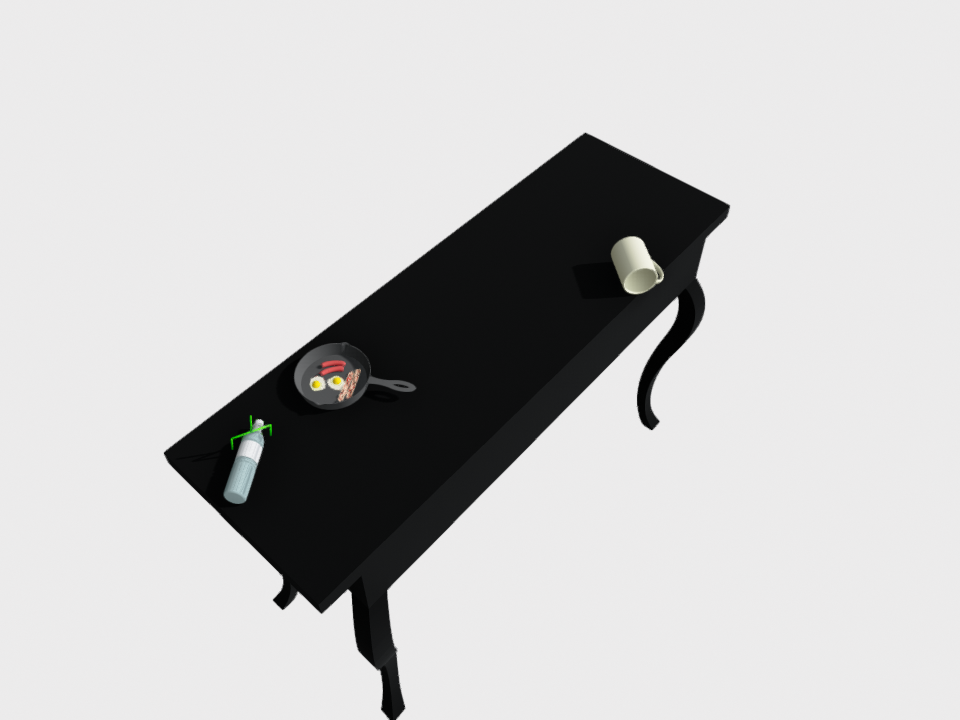

In [11]:
scene_mesh = trimesh_to_o3d(scene_trimesh_grasp.to_mesh())
img = renderer.render([scene_mesh], cam_info, np.linalg.inv(cam_pose))
Image.fromarray(img).show()